In [1]:
import os
import logging
import time
import glob
from shutil import copyfile
import openslide
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import pandas as pd
import cv2
import multiresolutionimageinterface as mir
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu
from skimage import feature
from skimage.feature import canny
import copy
import glob
import json
import random
from PIL import Image
from operator import itemgetter 
np.random.seed(0)

In [2]:
# Camelyon 2017
train_tif_cm17_path = '/media/mak/mirlproject1/CAMELYON17/training/dataset'
train_xml_cm17_path = '/media/mak/mirlproject1/CAMELYON17/training/groundtruth/lesion_annotations/XML'
train_json_cm17_path = '/media/mak/mirlproject1/CAMELYON17/training/groundtruth/lesion_annotations/json'
train_mask_cm17_path = '/media/mak/mirlproject1/CAMELYON17/training/groundtruth/lesion_annotations/Mask'
test_tif_cm17_path = '/media/mak/mirlproject1/CAMELYON17/testing/centers/dataset'

In [38]:
def BinMorphoProcessMask(mask):
    """
    Binary operation performed on tissue mask
    """
    close_kernel = np.ones((20, 20), dtype=np.uint8)
    image_close = cv2.morphologyEx(np.array(mask), cv2.MORPH_CLOSE, close_kernel)
    open_kernel = np.ones((5, 5), dtype=np.uint8)
    image_open = cv2.morphologyEx(np.array(image_close), cv2.MORPH_OPEN, open_kernel)
    return image_open 

def get_bbox(cont_img, rgb_image=None):
    contours, _ = cv2.findContours(cont_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rgb_contour = None
    if rgb_image is not None:
        rgb_contour = rgb_image.copy()
        line_color = (0, 0, 255)  # blue color code
        cv2.drawContours(rgb_contour, contours, -1, line_color, 2)
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    for x, y, h, w in bounding_boxes:
        rgb_contour = cv2.rectangle(rgb_contour,(x,y),(x+h,y+w),(0,255,0),2)
    return bounding_boxes, rgb_contour

def get_all_bbox_masks(mask, stride_factor):
    """
    Find the bbox and corresponding masks
    """
    bbox_mask = np.zeros_like(mask)
    bounding_boxes, _ = get_bbox(mask)
    y_size, x_size = bbox_mask.shape
    for x, y, h, w in bounding_boxes:
        x_min = x - stride_factor
        x_max = x + h + stride_factor
        y_min = y - stride_factor
        y_max = y + w + stride_factor
        if x_min < 0: 
         x_min = 0
        if y_min < 0: 
         y_min = 0
        if x_max > x_size: 
         x_max = x_size - 1
        if y_max > y_size: 
         y_max = y_size - 1      
        bbox_mask[y_min:y_max, x_min:x_max]=1
    return bbox_mask

def get_all_bbox_masks_with_stride(mask, stride_factor):
    """
    Find the bbox and corresponding masks
    """
    bbox_mask = np.zeros_like(mask)
    bounding_boxes, _ = get_bbox(mask)
    y_size, x_size = bbox_mask.shape
    for x, y, h, w in bounding_boxes:
        x_min = x - stride_factor
        x_max = x + h + stride_factor
        y_min = y - stride_factor
        y_max = y + w + stride_factor
        if x_min < 0: 
         x_min = 0
        if y_min < 0: 
         y_min = 0
        if x_max > x_size: 
         x_max = x_size - 1
        if y_max > y_size: 
         y_max = y_size - 1      
        bbox_mask[y_min:y_max:stride_factor, x_min:x_max:stride_factor]=1
        
    return bbox_mask

def find_largest_bbox(mask, stride_factor):
    """
    Find the largest bounding box encompassing all the blobs
    """
    y_size, x_size = mask.shape
    x, y = np.where(mask==1)
    bbox_mask = np.zeros_like(mask)
    x_min = np.min(x) - stride_factor
    x_max = np.max(x) + stride_factor
    y_min = np.min(y) - stride_factor
    y_max = np.max(y) + stride_factor
    
    if x_min < 0: 
     x_min = 0
    
    if y_min < 0: 
     y_min = 0

    if x_max > x_size: 
     x_max = x_size - 1
    
    if y_min > y_size: 
     y_max = y_size - 1    
    
    bbox_mask[x_min:x_max, y_min:y_max]=1
    return bbox_mask
    
# Functions
def ReadWholeSlideImage(image_path, level=None):
    """
    # =========================
    # Read Whole-Slide Image 
    # =========================
    """
    try:
        wsi_obj = openslide.OpenSlide(image_path)
        n_levels = wsi_obj.level_count
#         print("Number of Levels", n_levels)
#         print("Dimensions:%s, level_dimensions:%s"%(wsi_obj.dimensions, wsi_obj.level_dimensions))
#         print("Level_downsamples:", wsi_obj.level_downsamples)        
#         print("Properties", wsi_obj.properties)     
        if (level is None) or (level > n_levels-1):
            print ('Default')
            level = n_levels-1
        image_data = np.transpose(np.array(wsi_obj.read_region((0, 0),
                           level,
                           wsi_obj.level_dimensions[level]).convert('RGB')),
                           axes=[1, 0, 2])
        return wsi_obj, image_data, level
    except openslide.OpenSlideUnsupportedFormatError:
        print('Exception: OpenSlideUnsupportedFormatError')
    
def TissueMaskGeneration(slide_obj, level, RGB_min=50):
    img_RGB = np.transpose(np.array(slide_obj.read_region((0, 0),
                       level,
                       slide_obj.level_dimensions[level]).convert('RGB')),
                       axes=[1, 0, 2])
    img_HSV = rgb2hsv(img_RGB)
    background_R = img_RGB[:, :, 0] > threshold_otsu(img_RGB[:, :, 0])
    background_G = img_RGB[:, :, 1] > threshold_otsu(img_RGB[:, :, 1])
    background_B = img_RGB[:, :, 2] > threshold_otsu(img_RGB[:, :, 2])
    tissue_RGB = np.logical_not(background_R & background_G & background_B)
    tissue_S = img_HSV[:, :, 1] > threshold_otsu(img_HSV[:, :, 1])
    min_R = img_RGB[:, :, 0] > RGB_min
    min_G = img_RGB[:, :, 1] > RGB_min
    min_B = img_RGB[:, :, 2] > RGB_min

    tissue_mask = tissue_S & tissue_RGB & min_R & min_G & min_B
    return tissue_mask

def TissueMaskGeneration_BIN(slide_obj, level):
    img_RGB = np.transpose(np.array(slide_obj.read_region((0, 0),
                       level,
                       slide_obj.level_dimensions[level]).convert('RGB')),
                       axes=[1, 0, 2])    
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2HSV)
    img_S = img_HSV[:, :, 1]
    _,tissue_mask = cv2.threshold(img_S, 0, 255, cv2.THRESH_BINARY)
    return np.array(tissue_mask)

def TissueMaskGeneration_BIN_OTSU(slide_obj, level):
    img_RGB = np.transpose(np.array(slide_obj.read_region((0, 0),
                       level,
                       slide_obj.level_dimensions[level]).convert('RGB')),
                       axes=[1, 0, 2])    
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2HSV)
    img_S = img_HSV[:, :, 1]
    _,tissue_mask = cv2.threshold(img_S, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return np.array(tissue_mask)

# Image Helper Functions
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage:
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    axis_off = kwargs.get('axis_off','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
            if axis_off: 
              plt.axis('off')  
    plt.show()

In [41]:
patient_case = 'center_0/patient_017_node_1.tif'
patient_path = os.path.join(train_tif_cm17_path, patient_case)

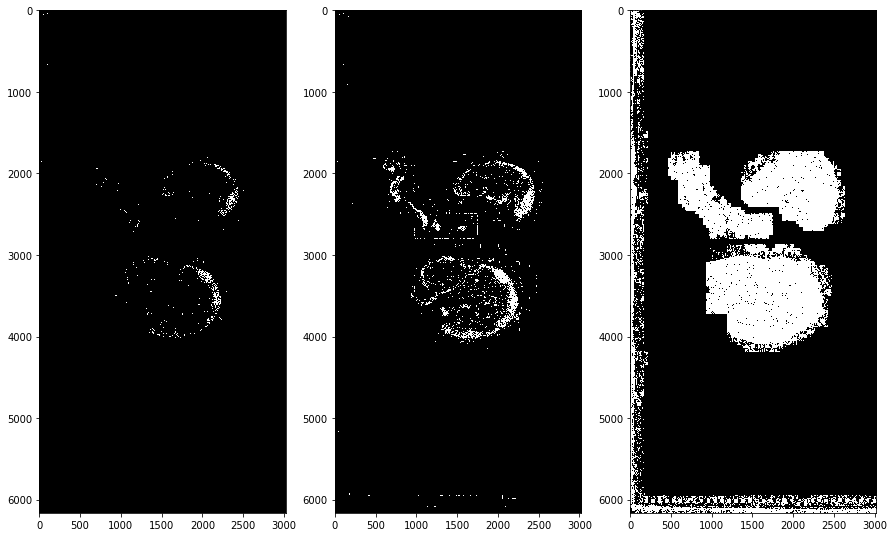

In [42]:
slide_obj, rgb_img, level = ReadWholeSlideImage(patient_path, level=5)
tissue_mask = TissueMaskGeneration(slide_obj, level=level)
tissue_mask_v1 = TissueMaskGeneration_BIN_OTSU(slide_obj, level=level)
tissue_mask_v2 = TissueMaskGeneration_BIN(slide_obj, level=level)
imshow(tissue_mask.T, tissue_mask_v1.T, tissue_mask_v2.T)

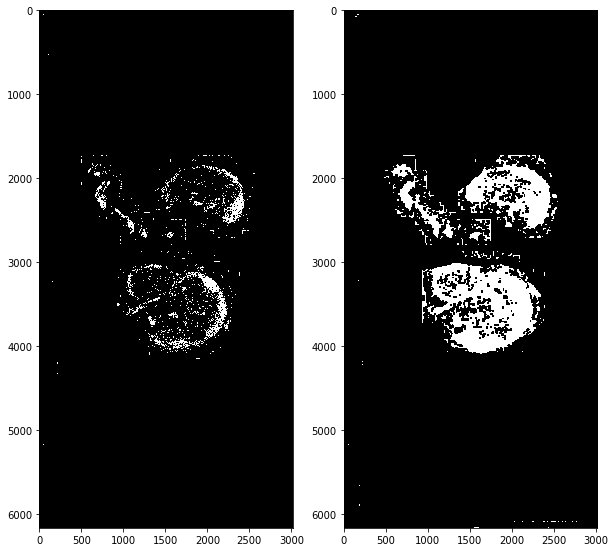

In [47]:
tissue_mask = tissue_mask_v1
processed_bin_mask = BinMorphoProcessMask(np.uint8(tissue_mask))
imshow(tissue_mask.T, processed_bin_mask.T)

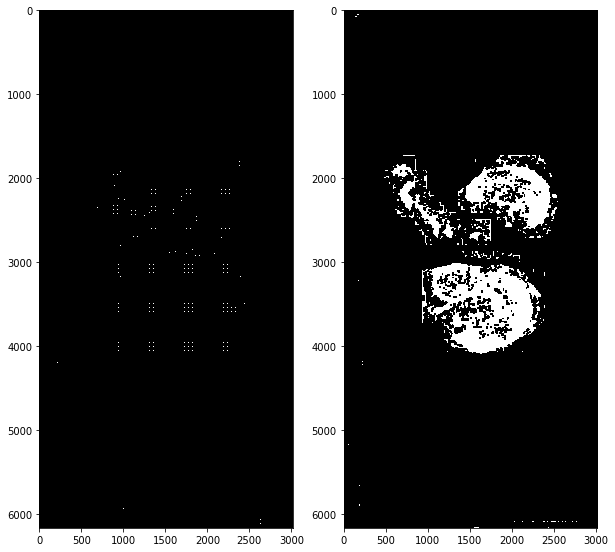

In [48]:
factor = 16
all_bbox_mask_with_strided = get_all_bbox_masks_with_stride(processed_bin_mask, factor)
imshow(all_bbox_mask_with_strided.T, processed_bin_mask.T)

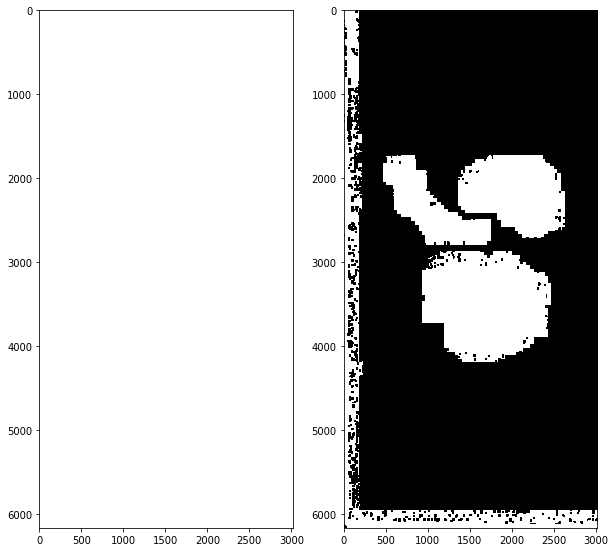

In [45]:
factor = 16
all_bbox_mask = get_all_bbox_masks(processed_bin_mask, factor)
imshow(all_bbox_mask.T, processed_bin_mask.T)

In [46]:
bbox_mask = find_largest_bbox(processed_bin_mask, factor)
ones_mask = np.zeros_like(bbox_mask)
ones_mask[::factor, ::factor] = bbox_mask[::factor, ::factor]
imshow(ones_mask.T, ones_mask.T*all_bbox_mask.T, all_bbox_mask_with_strided.T)

ValueError: zero-size array to reduction operation minimum which has no identity

In [11]:
x, y = np.where(ones_mask)
x_min = np.min(x)
x_max = np.max(x)
y_min = np.min(y)
y_max = np.max(y)
print(x_min, x_max, y_min, y_max)
print(np.count_nonzero(bbox_mask))
print(np.count_nonzero(ones_mask))
print(np.count_nonzero(ones_mask*all_bbox_mask))
print(np.count_nonzero(all_bbox_mask_with_strided))
print(np.count_nonzero(bbox_mask*all_bbox_mask))

32 2176 64 2080
4402930
17145
1966
4515
503048


In [12]:
p = np.ones((10,10))

In [13]:
p[0:2:10, 0:2:10]

array([[1.]])

In [14]:
p 

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])